In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch.nn.functional as F
from torchinfo import summary

In [2]:
df = pd.read_csv(r"C:\Users\hdgn5\OneDrive\Masaüstü\pytorch fundementals\ANN\Datasets\heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
df.shape

(299, 13)

In [4]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [5]:
# sns.pairplot(df)

In [6]:
x = df.drop("DEATH_EVENT" ,axis=1).values
y = df["DEATH_EVENT"]

In [7]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [8]:
# doğru hali
y_train = y_train.values if hasattr(y_train, "values") else y_train
y_test = y_test.values if hasattr(y_test, "values") else y_test


In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [10]:
train_dataset = TensorDataset(X_train , y_train)
test_dataset = TensorDataset(X_test , y_test)

In [11]:
train_loader = DataLoader(train_dataset , batch_size=32 , shuffle=True)
test_loader = DataLoader(test_dataset , batch_size=32 , shuffle=False)

In [24]:
class ANN_MODEL(nn.Module):
    def __init__(self, input_dim , hidden_layers=[128,64,32,16,8], dropout=0.4):
        super(ANN_MODEL ,self).__init__()

        self.layers = nn.ModuleList()
        in_dim = input_dim

        for h_dim in hidden_layers:
            self.layers.append(nn.Linear(in_dim,h_dim))
            in_dim = h_dim

        self.out = nn.Linear(in_dim,1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self , x):
        for layer in self.layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.out(x)

        return x 

In [25]:
model = ANN_MODEL(input_dim=X_train.shape[1])
print(model)

ANN_MODEL(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): Linear(in_features=16, out_features=8, bias=True)
  )
  (out): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [14]:
losfonk = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr =0.001 ,  weight_decay= 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min", factor=0.5 , patience=20)

In [15]:
summary(
    model, 
    input_size=(128, X_train.shape[1])  
)

Layer (type:depth-idx)                   Output Shape              Param #
ANN_MODEL                                [128, 1]                  --
├─ModuleList: 1-9                        --                        (recursive)
│    └─Linear: 2-1                       [128, 128]                1,664
├─Dropout: 1-2                           [128, 128]                --
├─ModuleList: 1-9                        --                        (recursive)
│    └─Linear: 2-2                       [128, 64]                 8,256
├─Dropout: 1-4                           [128, 64]                 --
├─ModuleList: 1-9                        --                        (recursive)
│    └─Linear: 2-3                       [128, 32]                 2,080
├─Dropout: 1-6                           [128, 32]                 --
├─ModuleList: 1-9                        --                        (recursive)
│    └─Linear: 2-4                       [128, 16]                 528
├─Dropout: 1-8                         

In [16]:
num_epochs = 100
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):

    model.train()  
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()            # Önceki gradyanları sıfırla
        outputs = model(X_batch)         # Forward pass
        loss = losfonk(outputs, y_batch)  # Loss hesaplama
        loss.backward()                  # Backward pass
        optimizer.step()                 # Parametre güncelleme
        running_loss += loss.item() * X_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    scheduler.step(epoch_loss)
    

    model.eval()  
    with torch.no_grad(): 
        y_pred = model(X_test)
        y_pred_label = (torch.sigmoid(y_pred) >= 0.5).float()  # 0.5 eşik 
        accuracy = (y_pred_label == y_test).sum().item() / y_test.size(0)
        test_accuracies.append(accuracy)
    

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Test Accuracy: {accuracy*100:.2f}%")


Epoch [1/100] | Loss: 0.7356 | Test Accuracy: 41.67%
Epoch [2/100] | Loss: 0.7238 | Test Accuracy: 41.67%
Epoch [3/100] | Loss: 0.7224 | Test Accuracy: 41.67%
Epoch [4/100] | Loss: 0.7147 | Test Accuracy: 41.67%
Epoch [5/100] | Loss: 0.7051 | Test Accuracy: 55.00%
Epoch [6/100] | Loss: 0.6931 | Test Accuracy: 58.33%
Epoch [7/100] | Loss: 0.6646 | Test Accuracy: 58.33%
Epoch [8/100] | Loss: 0.6401 | Test Accuracy: 58.33%
Epoch [9/100] | Loss: 0.6072 | Test Accuracy: 58.33%
Epoch [10/100] | Loss: 0.5731 | Test Accuracy: 58.33%
Epoch [11/100] | Loss: 0.5549 | Test Accuracy: 58.33%
Epoch [12/100] | Loss: 0.5141 | Test Accuracy: 58.33%
Epoch [13/100] | Loss: 0.4719 | Test Accuracy: 65.00%
Epoch [14/100] | Loss: 0.4881 | Test Accuracy: 66.67%
Epoch [15/100] | Loss: 0.4719 | Test Accuracy: 71.67%
Epoch [16/100] | Loss: 0.4360 | Test Accuracy: 71.67%
Epoch [17/100] | Loss: 0.4626 | Test Accuracy: 73.33%
Epoch [18/100] | Loss: 0.4613 | Test Accuracy: 76.67%
Epoch [19/100] | Loss: 0.3952 | Test 

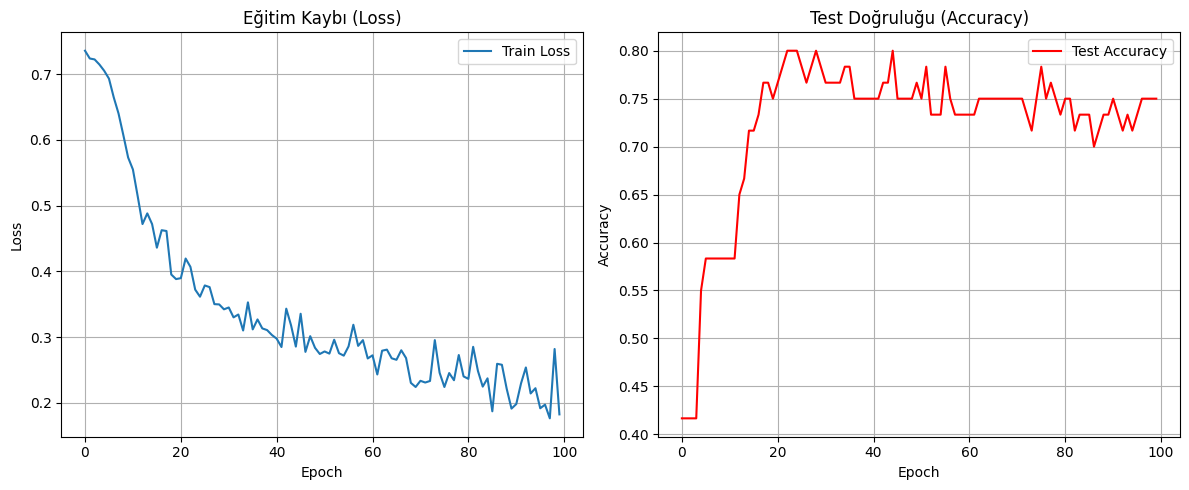

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].plot(train_losses, label="Train Loss")
axs[0].set_title("Eğitim Kaybı (Loss)")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)


axs[1].plot(test_accuracies, label="Test Accuracy", color="red")
axs[1].set_title("Test Doğruluğu (Accuracy)")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch.nn.functional as F
from torchinfo import summary

In [ ]:
df = pd.read_csv(r"C:\Users\hdgn5\OneDrive\Masaüstü\pytorch fundementals\ANN\Datasets\kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
deleted_colons = ["id" , "date"]

df = df.drop(columns=[col for col in deleted_colons if col in df.columns])

In [ ]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [ ]:
df.shape

(21613, 19)

<Axes: >

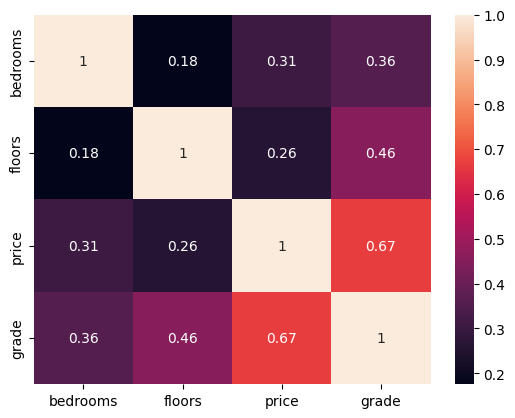

In [ ]:
sns.heatmap(df[["bedrooms", "floors", "price","grade"]].corr(), annot=True)


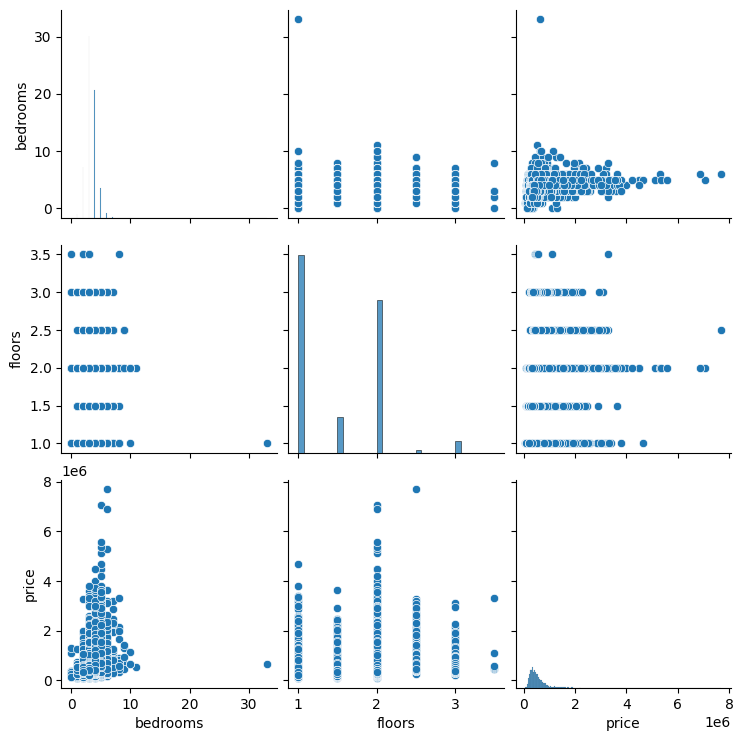

In [ ]:
sns.pairplot(df[["bedrooms", "floors", "price"]])

In [ ]:
x = df.drop("price" , axis=1).values
y = df["price"]

In [ ]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
X_train = torch.tensor(X_train , dtype=torch.float32)
X_test = torch.tensor(X_test , dtype = torch.float32)

y_train = torch.tensor(y_train.values , dtype = torch.float32).view(-1,1)
y_test = torch.tensor(y_test.values, dtype = torch.float32).view(-1,1)

In [ ]:
train_dataset = TensorDataset(X_train , y_train)
test_dataset = TensorDataset(X_test , y_test)

In [ ]:
train_loader = DataLoader(train_dataset , batch_size =32 , shuffle = True)
test_loader = DataLoader(test_dataset , batch_size=32 ,shuffle=False)

In [ ]:
class ANN(nn.Module):
    def __init__(self, input_dim, hidden=[256,128,64,32], dropout=0.3, out_activation=None):
        super().__init__()
        self.layers = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        self.out_activation = out_activation  # torch.sigmoid, lambda x: torch.softmax(x, dim=1) veya None

        prev = input_dim
        for h in hidden:
            self.layers.append(nn.Linear(prev, h))
            self.bn.append(nn.BatchNorm1d(h))
            prev = h

        self.out = nn.Linear(prev, 1)
        self._init_weights()

    def _init_weights(self):
        for layer in [*self.layers, self.out]:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        res = x
        for i, l in enumerate(self.layers):
            x = l(x)
            x = self.bn[i](x)
            x = F.relu(x)
            x = self.dropout(x)

            if i % 2 == 1:
                if res.shape[1] != x.shape[1]:
                    res = F.pad(res, (0, x.shape[1]-res.shape[1]))
                x = x + res
                res = x

        x = self.out(x)
        if self.out_activation:
            x = self.out_activation(x)
        return x


In [ ]:
loss_fonk = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=1E-3 , weight_decay=1e-4 )
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min", factor=0.5 , patience=10)

ANN(
  (layers): ModuleList(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
  (bn): ModuleList(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
summary(model, input_size= (128, X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
ANN                                      [128, 1]                  --
├─ModuleList: 1-10                       --                        (recursive)
│    └─Linear: 2-1                       [128, 256]                4,864
├─ModuleList: 1-11                       --                        (recursive)
│    └─BatchNorm1d: 2-2                  [128, 256]                512
├─Dropout: 1-3                           [128, 256]                --
├─ModuleList: 1-10                       --                        (recursive)
│    └─Linear: 2-3                       [128, 128]                32,896
├─ModuleList: 1-11                       --                        (recursive)
│    └─BatchNorm1d: 2-4                  [128, 128]                256
├─Dropout: 1-6                           [128, 128]                --
├─ModuleList: 1-10                       --                        (recursive)
│    └─Linear: 2-5             

In [ ]:
epoch_num = 100 
train_loss = []
test_acc =[]

In [ ]:
epoch_num = 100
train_loss = []
test_mse = []
test_r2 = []

for epoch in range(epoch_num):
    model.train()
    runn_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fonk(outputs, y_batch)
        loss.backward()
        optimizer.step()
        runn_loss += loss.item() * X_batch.size(0)

    epoch_loss = runn_loss / len(train_loader.dataset)
    train_loss.append(epoch_loss)
    scheduler.step(epoch_loss)

    model.eval()
    
    with torch.no_grad():
        y_pred = model(X_test)
        mse = ((y_pred - y_test) ** 2).mean().item()
        ss_res = ((y_test - y_pred) ** 2).sum()
        ss_tot = ((y_test - y_test.mean()) ** 2).sum()
        r2 = 1 - ss_res / ss_tot

        test_mse.append(mse)
        test_r2.append(r2.item())

    print(f"Epoch [{epoch+1}/{epoch_num}] | Loss: {epoch_loss:.4f} | Test MSE: {mse:.4f} | R2: {r2:.4f}")


Epoch [1/100] | Loss: 419816276915.5998 | Test MSE: 452907859968.0000 | R2: -1.9959
Epoch [2/100] | Loss: 419694762823.8103 | Test MSE: 452719706112.0000 | R2: -1.9946
Epoch [3/100] | Loss: 419436122020.5566 | Test MSE: 452291264512.0000 | R2: -1.9918
Epoch [4/100] | Loss: 419054758545.3973 | Test MSE: 451879174144.0000 | R2: -1.9891
Epoch [5/100] | Loss: 418587587716.5455 | Test MSE: 451285024768.0000 | R2: -1.9851
Epoch [6/100] | Loss: 418020283125.6060 | Test MSE: 450558656512.0000 | R2: -1.9803
Epoch [7/100] | Loss: 417393862325.9984 | Test MSE: 449848737792.0000 | R2: -1.9756
Epoch [8/100] | Loss: 416693643453.2831 | Test MSE: 449158119424.0000 | R2: -1.9711
Epoch [9/100] | Loss: 415921008301.2331 | Test MSE: 448354189312.0000 | R2: -1.9658
Epoch [10/100] | Loss: 415093827629.2479 | Test MSE: 447095472128.0000 | R2: -1.9574
Epoch [11/100] | Loss: 414176322429.5866 | Test MSE: 446120919040.0000 | R2: -1.9510
Epoch [12/100] | Loss: 413235952214.1724 | Test MSE: 445535354880.0000 | R

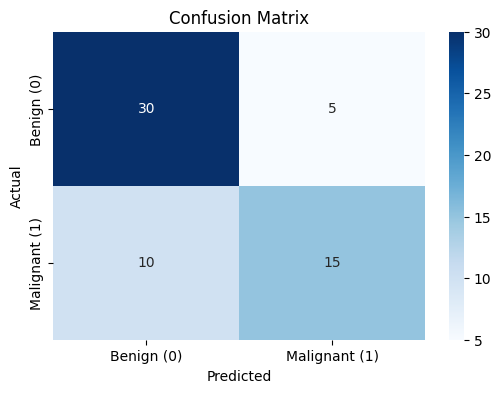

 Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.75      0.86      0.80        35
Malignant (1)       0.75      0.60      0.67        25

     accuracy                           0.75        60
    macro avg       0.75      0.73      0.73        60
 weighted avg       0.75      0.75      0.74        60



In [18]:
cm = confusion_matrix(y_test.numpy(), y_pred_label.numpy())

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign (0)", "Malignant (1)"], yticklabels=["Benign (0)", "Malignant (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


print(" Classification Report:")
print(classification_report(y_test.numpy(), y_pred_label.numpy(), target_names=["Benign (0)", "Malignant (1)"]))